### Generate the Official cb-WoFS Explainability Graphics 

In [1]:
# Box and Whisker plot for the top 5 predictors 
# pink line for a given example. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from display_names import to_display_name, to_units
import sys
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs_ml_severe.io.io import load_ml_data
from wofs.post.utils import load_yaml
import matplotlib.ticker as ticker

from sklearn.impute import SimpleImputer

lookup_file: /home/monte.flora/python_packages/WoF_post/wofs/data/psadilookup.dat


In [7]:
import math
import json 
import matplotlib.ticker as mtick

class cbWoFSExplainabilityGraphics:
    def __init__(self, X_train, y_train):
        
        # Only get where the examples are matched to reports.
        inds = np.where(y_train>0)[0]
    
        X_train_subset = X_train.iloc[inds, :]
        X_train_subset.reset_index(drop=True, inplace=True)
        
        #X_train_subset['mid_level_lapse_rate_ens_mean_spatial_mean'] /= -2.7
        #X_train_subset['low_level_lapse_rate_ens_mean_spatial_mean'] /= -3.0
        
        # Convert mid-level temps?  
        
        self.X_train = X_train_subset
        self.features = X_train_subset.columns 
        
        self.max_min_val_dict = { }
        
    def _round(self, value, mode):
        
        def round_to_nearest_fifth(x):    
            if x < 0:
                return -round_to_nearest_fifth(-x)
            elif x < 10:
                return x
            else:
                if mode=='upper': 
                    return math.ceil(x / 5,) * 5
                else:
                    return math.floor(x / 5,) * 5
        
        if value == 0.0:
            return 0.0, 0
    
        # Find the order of magnitude (oom)
        oom = int(math.log10(abs(value)))

        round_to_fifth = False
        if oom >= 0:
            # Positive Order of Mag. 
            if oom <= 1: 
                print('this happened!')
                round_int = 2
            else:
                round_int = 0
                round_to_fifth = True
        else:
            # Negative Order of Mag.
            if oom == -1:
                round_int = 2
            else:
                round_int = 4
 
        # Round to the nearest 5 for >=10 
        if round_to_fifth:
            return round_to_nearest_fifth(round(value, round_int)), round_int
        else:
            return round(value, round_int), round_int

    def create_global(self, features, target):
        """Create the global explainability graphic"""
        f, axes = plt.subplots(dpi=192, nrows=5, 
                           figsize=(800/192, 800/192))
        for ax, feature in zip(axes, features):
            self.create_local(feature, ax=ax, f=f)
        
        title = f"""
        Training Set Distribution\n(All {target}-Producing Storms)\nfor the Top 5 Predictors (out of 113)"""
    
        f.suptitle(title, 
               fontsize=8, y=1.10)
        
        axes[0].set_title('Red numbers and vertical bars\nshow current values for this object', 
                      fontsize=6, pad=12, color='red')
        
        plt.subplots_adjust(hspace=1.4)
        
        return f, axes 
                
    def create_local(self, feature, target, f=None, ax=None):
        """Create box-and-whisker graphic for a single feature"""  
        units = to_units(feature)
        pretty_name = to_display_name(feature)
    
        if ax is None:
            f, ax = plt.subplots(dpi=192, nrows=1, 
                           figsize=(800/192, 100/192))
        
        # Despine and only leave the bottom side. 
        for side in ['top', 'right', 'left']: 
            ax.spines[side].set_visible(False)

        # Remove y tick labels 
        whis=[0.01, 99.9]
        ax.tick_params(axis='x', labelsize=9, size=8)
        min_val, _ = self._round(np.nanpercentile(self.X_train[feature], whis[0]), 'lower')
        max_val, round_int = self._round(np.nanpercentile(self.X_train[feature], whis[-1]), 'upper')
        
        self.max_min_val_dict[f'{feature}___{target}'] = {'max_val' : max_val,
                                          'min_val' : min_val, }
        
        self.max_min_val_dict[f'{feature}'] = {'round_int' : round_int}
        

        # Create the box-and-whiskers 
        box_plot = ax.boxplot(x=self.X_train[feature], vert=False, 
                              whis=whis, patch_artist=True, 
                              widths=0.3, showfliers=False )
        ax.set_yticks([],)
        
        # Create a title for the feature name. 
        ax.annotate(fr'{pretty_name} ({units})', xy=(0, 1.15),
                    xycoords='axes fraction', fontsize=6, ha='left', color = 'k', fontweight='bold')
            
        # Identify pretty tick ranges 
        ax.set_xlim(min_val, max_val)
        
        # set the tick locator for the x-axis
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
        
        rng = list(ax.get_xticks())
        levels = [f"{round(v, round_int)}" for v in rng]

        levels[0] = ''; levels[-1] = ''
        ax.set_xticks(rng)
        ax.set_xticklabels(labels=levels)

        # fill with colors
        color = 'xkcd:medium blue'
        for patch in box_plot['boxes']:
            patch.set_facecolor(color)
        for line in box_plot['medians']:
            line.set_color('k')

        return f, ax
    
    def save_local(self, fig, feature, target):
        plt.savefig(
            f"new_graphics/{feature}___{target}_explainability_background.png", 
            format="png", dpi=192, bbox_inches="tight", pad_inches=0.0)
        plt.close(fig) 
    
    def save_global(self, fig, target):
        plt.savefig(
            f"new_graphics/{target}_global_explainability_background.png", 
            format="png", dpi=192, bbox_inches="tight", pad_inches=0.0)
        plt.close(fig) 
    
    
    def save_json(self, target): 
        with open(f"../json/min_max_vals_{target}.json", "w") as outfile:
            json.dump(self.max_min_val_dict, outfile)

### Create the Explainability Graphic Per Feature For Each Hazard

1. Only using the severe hail dataset 

In [3]:
def get_target_str(target):
    # Initialize the kwargs for the hyperparameter optimization.
    if isinstance(target, list):
        if 'sig_severe' in target[0]:
            target = 'all_sig_severe'
        else:
            target = 'all_severe'
   
    return target 

In [4]:
%matplotlib inline
target = 'hail_severe_0km'

data = joblib.load(
    '/work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_all_severe_None_first_hour_realtime.joblib')
features = data['X'].columns

target_str = get_target_str(target)
print(target_str.upper())
df, y_train, metadata = load_ml_data(target, 
                 lead_time = 'first_hour', 
                 mode = None, 
                 baseline=False,
                 return_only_df=False, 
                 load_reduced=True, 
                 base_path = '/work/mflora/ML_DATA/DATA',
                )
X_train = df[features]            
        
# Impute missing values. 
X_train = pd.DataFrame(SimpleImputer().fit_transform(X_train), columns=X_train.columns)

HAIL_SEVERE_0KM
Only keeping warm season cases for the official training!


In [5]:
list(features)

['theta_e__ens_mean__spatial_mean',
 'u_10__ens_mean__spatial_mean',
 'v_10__ens_mean__spatial_mean',
 'temperature_850__ens_mean__spatial_mean',
 'temperature_700__ens_mean__spatial_mean',
 'temperature_500__ens_mean__spatial_mean',
 'td_850__ens_mean__spatial_mean',
 'td_700__ens_mean__spatial_mean',
 'td_500__ens_mean__spatial_mean',
 'mid_level_lapse_rate__ens_mean__spatial_mean',
 'low_level_lapse_rate__ens_mean__spatial_mean',
 'geo_hgt_850__ens_mean__spatial_mean',
 'geo_hgt_500__ens_mean__spatial_mean',
 'geo_hgt_700__ens_mean__spatial_mean',
 'QVAPOR_850__ens_mean__spatial_mean',
 'QVAPOR_700__ens_mean__spatial_mean',
 'QVAPOR_500__ens_mean__spatial_mean',
 'qv_2__ens_mean__spatial_mean',
 'freezing_level__ens_mean__spatial_mean',
 'srh_0to1__ens_mean__spatial_mean',
 'srh_0to3__ens_mean__spatial_mean',
 'srh_0to500__ens_mean__spatial_mean',
 'shear_u_0to6__ens_mean__spatial_mean',
 'shear_v_0to6__ens_mean__spatial_mean',
 'shear_u_0to1__ens_mean__spatial_mean',
 'shear_v_0to1

### Test a Single Individual Panel

this happened!


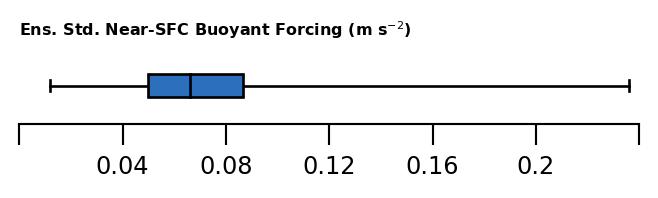

In [9]:
%matplotlib inline
feature = 'buoyancy__time_min__ens_std__spatial_mean'

explainer = cbWoFSExplainabilityGraphics(X_train.astype(float), y_train)
fig, _ = explainer.create_local(feature, target_str)

#explainer.save_local(fig, feature, target_str)

### Create Individual Panels 

In [4]:
targets = ['wind_severe_0km', 
           'hail_severe_0km', 
           'tornado_severe_0km', 
           ['wind_severe_0km', 'hail_severe_0km', 'tornado_severe_0km'],
           ['wind_sig_severe_0km', 'hail_sig_severe_0km', 'tornado_sig_severe_0km']
          ]

data = joblib.load(
    '/work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_all_severe_None_first_hour_realtime.joblib')
features = data['X'].columns

for target in targets:
    target_str = get_target_str(target)
    print(target_str.upper())
    df, y_train, metadata = load_ml_data(target, 
                 lead_time = 'first_hour', 
                 mode = None, 
                 baseline=False,
                 return_only_df=False, 
                 load_reduced=True, 
                 base_path = '/work/mflora/ML_DATA/DATA',
                )
    X_train = df[features]            
         
    # Impute missing values. 
    X_train = pd.DataFrame(SimpleImputer().fit_transform(X_train), columns=X_train.columns)
        
    explainer = cbWoFSExplainabilityGraphics(X_train.astype(float), y_train)
    
    for feature in X_train.columns: 
        fig, _ = explainer.create_local(feature, target_str)
        explainer.save_local(fig, feature, target_str)
        
    explainer.save_json(target_str)    

WIND_SEVERE_0KM
Only keeping warm season cases for the official training!
HAIL_SEVERE_0KM
Only keeping warm season cases for the official training!
TORNADO_SEVERE_0KM
Only keeping warm season cases for the official training!
ALL_SEVERE
Only keeping warm season cases for the official training!
ALL_SIG_SEVERE
Only keeping warm season cases for the official training!


In [5]:
X_train.shape

(852435, 142)

In [6]:
# Save all the jsons together! 
from glob import glob
files = glob("../json/min_max_vals*")
pd.read_json(files[0])

,theta_e__ens_mean__spatial_mean___wind_severe_0km,theta_e__ens_mean__spatial_mean,u_10__ens_mean__spatial_mean___wind_severe_0km,u_10__ens_mean__spatial_mean,v_10__ens_mean__spatial_mean___wind_severe_0km,v_10__ens_mean__spatial_mean,temperature_850__ens_mean__spatial_mean___wind_severe_0km,temperature_850__ens_mean__spatial_mean,temperature_700__ens_mean__spatial_mean___wind_severe_0km,temperature_700__ens_mean__spatial_mean,...,cin_mu__ens_mean__spatial_mean___wind_severe_0km,cin_mu__ens_mean__spatial_mean,lcl_mu__ens_mean__spatial_mean___wind_severe_0km,lcl_mu__ens_mean__spatial_mean,cape_mu__ens_std__spatial_mean___wind_severe_0km,cape_mu__ens_std__spatial_mean,cin_mu__ens_std__spatial_mean___wind_severe_0km,cin_mu__ens_std__spatial_mean,lcl_mu__ens_std__spatial_mean___wind_severe_0km,lcl_mu__ens_std__spatial_mean
max_val,370.0,NaN,22.8,NaN,21.4,NaN,81.9,NaN,55.2,NaN,...,-0.1,NaN,3095.0,NaN,1360.0,NaN,130.0,NaN,940.0,NaN
min_val,315.0,NaN,-24.2,NaN,-23.6,NaN,47.6,NaN,31.1,NaN,...,-265.0,NaN,170.0,NaN,25.5,NaN,0.0,NaN,25.4,NaN
round_int,NaN,0.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,...,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


In [7]:
top_preds = {'tornado_severe_0km' : 
            ['wz_0to2_instant__time_max__amp_ens_mean_spatial_perc_90', 
             'shear_v_0to6__ens_mean__spatial_mean',
             'buoyancy__time_min__amp_ens_mean_spatial_perc_10',
             '10-500m_bulkshear__time_max__amp_ens_mean_spatial_perc_90',
             'v_10__ens_mean__spatial_mean',
            ],
            'hail_severe_0km' : 
                    [
              'dbz_3to5__time_max__ens_mean__spatial_mean',
              'comp_dz__time_max__amp_ens_mean_spatial_perc_90',  
              'td_850__ens_mean__spatial_mean',
              '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
              'w_down__time_min__amp_ens_mean_spatial_perc_10'
    
            ],
            'wind_severe_0km' : 
                    [
                  'v_10__ens_mean__spatial_mean',
                  'ws_80__time_max__amp_ens_mean_spatial_perc_90',
                  'comp_dz__time_max__amp_ens_mean_spatial_perc_90',
                  'div_10m__time_min__ens_mean__spatial_mean',
                  'buoyancy__time_min__amp_ens_mean_spatial_perc_10',  
                    ],
             
             'all_severe' : 
             [
                'comp_dz__time_max__amp_ens_mean_spatial_perc_90',
                'div_10m__time_min__ens_std__spatial_mean',
                'ctt__time_min__amp_ens_mean_spatial_perc_10',
                'hailcast__time_max__ens_mean__spatial_mean',
                '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
                ],
             'all_sig_severe': [
                'low_level_lapse_rate__ens_mean__spatial_mean',
                'ctt__time_min__amp_ens_mean_spatial_perc_10',
                '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
                'hailcast__time_max__ens_mean__spatial_mean',
                'comp_dz__time_max__amp_ens_mean_spatial_perc_90', 
                ],
             
            }

In [8]:
X_train, y_train, metadata = load_ml_data('wind_severe_0km', 
                 lead_time = 'first_hour', 
                 mode = None, 
                 baseline=False,
                 return_only_df=False, 
                 load_reduced=True, 
                 base_path = '/work/mflora/ML_DATA/DATA',
                )

Only keeping warm season cases for the official training!


In [9]:
top_features = top_preds['wind_severe_0km']

dataframe = X_train.iloc[:10, :]

n_examples = len(dataframe)

top_values = dataframe[top_features].values 
top_features_list = [list(top_features) for _ in range(n_examples)]

val_df = pd.DataFrame(top_values, columns=[f'Feature Val {i+1}' for i in range(5)])
feature_df = pd.DataFrame(top_features_list, columns=[f'Feature Name {i+1}' for i in range(5)])
    
total_df = pd.concat([val_df, feature_df], axis=1)


In [10]:
top_values.shape, n_examples

((10, 5), 10)

In [11]:
total_df

,Feature Val 1,Feature Val 2,Feature Val 3,Feature Val 4,Feature Val 5,Feature Name 1,Feature Name 2,Feature Name 3,Feature Name 4,Feature Name 5
0,2.979249,32.241062,58.144615,-0.001249,0.019111,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
1,8.587055,33.845581,57.457897,-0.001377,0.049946,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
2,5.907899,33.662289,53.209633,-0.000913,0.127450,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
3,12.132035,28.518232,41.893486,-0.000223,0.298093,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
4,13.421385,30.055084,48.336456,-0.001074,0.253420,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
5,2.366331,32.440594,58.130207,-0.001020,0.019398,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
6,6.707975,33.830479,57.482117,-0.001054,0.051098,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
7,5.106850,33.789391,53.261978,-0.000851,0.131042,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
8,11.567306,28.674524,40.603516,-0.000210,0.303031,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10
9,12.778464,30.188175,49.244877,-0.001094,0.238252,v_10__ens_mean__spatial_mean,ws_80__time_max__amp_ens_mean_spatial_perc_90,comp_dz__time_max__amp_ens_mean_spatial_perc_90,div_10m__time_min__ens_mean__spatial_mean,buoyancy__time_min__amp_ens_mean_spatial_perc_10


### Create the top 5 predictor global panel 